In [1]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from tensorflow import keras
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from joblib import dump, load
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout

# Modelos de redes neuronales

Apliquemos a continuación Modelos de Redes Neuronales a nuestra serie de tiempo, para conocer el comportamiento del pronóstico que se puede alcanzar a partir de estos. En este apartado estaremos aplicando:

1. Recurrent neural networks
2. Multilayer-perceptron
3. Long-short term memory

Durante el análisis se estarán construyendo modelos para distintas combinaciones de épocas, input layers, neuronas y tasas de drop-out.

Cada una de los apartados a continuación incluyen funciones de creación de la red neuronal, además se diseñó una función que retorna el mejor modelo en cada caso, para automatizar la creación y selección para cada combinación. Carguemos los datos:

In [2]:
df=pd.read_excel("loadsts.xlsx")
df.index = df['Posted_date']
df.index.freq = 'D'
ts = df['Loads']

En el caso de red neuronales, escalaremos los datos con el fin de disminuir el tiempo de alcance de la convergencia.

In [3]:
df['loads_escaler'] = df['Loads']
scaler = MinMaxScaler(feature_range=(0, 1))
ts_esc = scaler.fit_transform(np.array(df['loads_escaler']).reshape(-1, 1))

## 1. Funciones complementarias

Al igual que en los otros capítulos estaremos usando las funciones de apoyo para separación de la serie, evaluación de supuestos y evaluación de los 'score' de pronóstico.

In [4]:
def split(serie, trainportion):
    perct = math.ceil(len(ts) * trainportion)
    perc2 = math.ceil(len(ts)*((1 - trainportion)/2))
    train = serie[0:perct]
    validation = serie[perct:perct+perc2]
    test = serie[perct+perc2:]
    return train, validation, test

In [5]:
#calculo de los errores
def errors(y_pred, y_real):
    
    mae = mean_absolute_error(y_real, y_pred)
    mape = 100*(sum(abs(((y_real - y_pred)/y_real)))/len(y_real))
    mse = mean_squared_error(y_real , y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    
    return mae, mape, mse, rmse, r2

In [6]:
#evaluacion de supuestos
def assumptions(residuals):

    warning = ""
    a = 0
    
    #Independency
    #H0: The residuals are independent.
    #H1: The residuals aren't independent.    
    ljung_box_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    ljung_box_pvalue = ljung_box_test['lb_pvalue'].values[0]
    if ljung_box_pvalue < 0.05:
        warning= warning + " The residuals aren't independent"
        a=a+1

    #Normality test
    #H0: The residuals have a normal distribution.
    #H1: The residuals don't have a normal distribution.
    jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)
    if jb_pvalue < 0.05:
        a = a+1
        warning = warning + " The residuals do not follow a normal distribution"

    #homocedasticity
    #H0: The residuals are homocedastic.
    #H1: The residuals aren't homocedastic.
    arch_stat, arch_pvalue, _, _ = het_arch(residuals)
    if arch_pvalue < 0.05:
        warning= warning + " The residuals aren't homocedastic"
        a=a+1

    return arch_pvalue, jb_pvalue, ljung_box_pvalue, warning

A continuación la función con que pronosticaremos los valores de validación y testing para el cálculo de los errores y desempeño del modelo.

In [197]:
#forecast
def forecast_nw(best_model, X_val):
    preds = best_model.predict(X_val)
    preds = scaler.inverse_transform(preds)
    preds = np.squeeze(preds)
    return preds

Además, agregaremos la función _makeXy_ que se encarga de organizar la serie de tiempo en un arreglo matricial que genera el input layer de $nbtimesteps$ y la predicción $y$ de un valor a la vez. Durante la selección del mejor modelo de cada tipo de red neuronal estaremos probando esta división para los valores de 3, 4, 5 días para entrenar la red.

In [7]:
def makeXy(ts, nbtimesteps):
    X = []
    y = []
    for i in range(nbtimesteps, ts.shape[0]):
        X.append(list(ts[i-nbtimesteps:i-1])) #Regressors
        y.append(ts[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

El conjunto de entrenamiento tendrá el 80% datos en este entrenamiento de red neuronal. Guardaremos los conjuntos con los valores reales y los valores escalados a continuación:

In [8]:
train, val, test = split(ts, 0.8)
train_esc, val_esc, test_esc = split(ts_esc, 0.8)

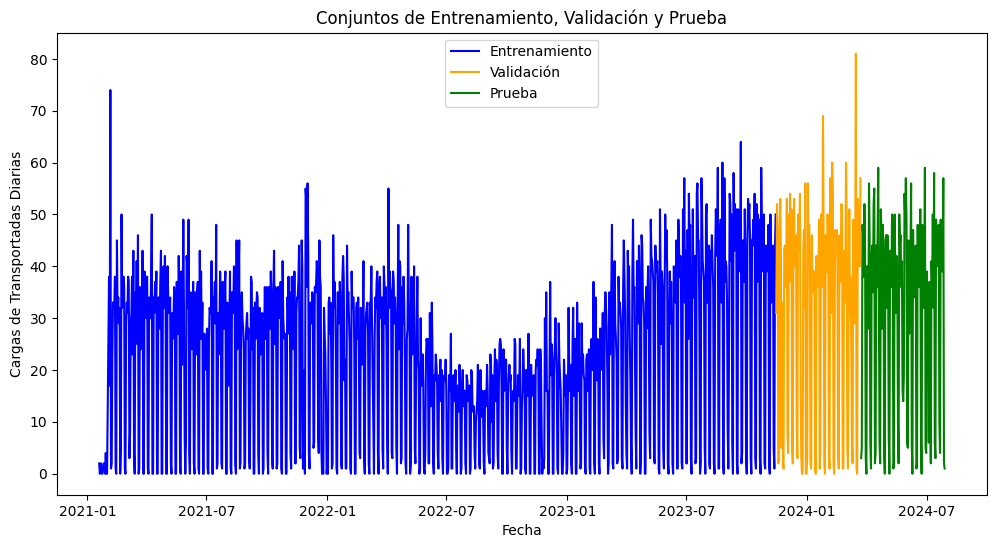

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, color='blue', label='Entrenamiento')
plt.plot(val.index, val, color='orange', label='Validación')
plt.plot(test.index, test, color='green', label='Prueba')

plt.title('Conjuntos de Entrenamiento, Validación y Prueba')
plt.xlabel('Fecha')
plt.ylabel('Cargas de Transportadas Diarias')
plt.legend()

plt.show()

## 2. Selección de la función de activación

La función de activación a través de la red neuronal juega un papel crítico en el cálculo de los pesos de cada capa. Existen distintas funciones de activación como 'tanh', 'relu', 'sigmoid', entre otras. A continuación haremos una prueba rápida comparando el desempeño de la red neuronal cuando usamos 'tanh' y cuando usamos 'relu', para conocer cuál mejora el desempeño de las métricas de error.

Dividamos además el conjunto de training, validación y test para esta prueba.

In [171]:
X_train, y_train = makeXy(train_esc, 3+1)
X_val, y_val = makeXy(val_esc, 3+1)
X_trainr, y_trainr = makeXy(train, 3+1)
X_valr, y_valr = makeXy(val, 3+1)

### 2.1 Test modelo con uso de función 'tanh'

En este paso estamos generando el modelo de red neuronal Multilayer Perceptron (MLP) para un input de 3 datos, 100 neuronas y una tasa de drop-out de 0.2, estos mismos parámetros los utilizaremos cuando creamos la red neuronal con 'relu'.

In [182]:
input_layer = Input(shape=(3,), dtype='float32')
dense1 = Dense(100, activation='tanh')(input_layer)
dropout_layer = Dropout(0.2)(dense1)
output_layer = Dense(1, activation='linear')(dropout_layer)

modeltanh = Model(inputs=input_layer, outputs=output_layer)
modeltanh.compile(loss='mean_squared_error', optimizer='adam')

En el siguiente paso guardamos en una carpeta los distintos modelos generados en las épocas revisadas, en este caso solo 10. De estos modelos seleccionaremos el que mejor 'val_loss' tenga, es decir el que mejor pronóstico de la validación alcanzó.

In [183]:
save_weights_at = os.path.join('keras_models', f'{modeltanh.name}_weights_batch{16}_{{epoch:02d}}-{{val_loss:.4f}}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');

history_filename = os.path.join('historynn', f'history_{modeltanh.name}_batch{16}.joblib')
history_airp = None

if os.path.exists(history_filename):
    history_filename = history_filename
    print("El archivo '{history_filename}' ya existe. Se ha cargado el historial del entrenamiento.")
        
else:
    history_airp = modeltanh.fit(x=X_train, y=y_train, batch_size=16, epochs=10,
                             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
                             shuffle=True);
    dump(history_airp.history, history_filename)
    print("El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'")

Epoch 1/10
65/65 - 1s - 16ms/step - loss: 0.0597 - val_loss: 0.0739
Epoch 2/10
65/65 - 0s - 4ms/step - loss: 0.0453 - val_loss: 0.0824
Epoch 3/10
65/65 - 0s - 4ms/step - loss: 0.0431 - val_loss: 0.0805
Epoch 4/10
65/65 - 0s - 5ms/step - loss: 0.0435 - val_loss: 0.0725
Epoch 5/10
65/65 - 0s - 3ms/step - loss: 0.0432 - val_loss: 0.0778
Epoch 6/10
65/65 - 0s - 3ms/step - loss: 0.0422 - val_loss: 0.0729
Epoch 7/10
65/65 - 0s - 4ms/step - loss: 0.0424 - val_loss: 0.0742
Epoch 8/10
65/65 - 0s - 3ms/step - loss: 0.0429 - val_loss: 0.0827
Epoch 9/10
65/65 - 0s - 4ms/step - loss: 0.0416 - val_loss: 0.0767
Epoch 10/10
65/65 - 0s - 2ms/step - loss: 0.0425 - val_loss: 0.0764
El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'


In [184]:
model_dir = 'keras_models'
files = os.listdir(model_dir)
pattern = rf"{re.escape(modeltanh.name)}_weights_batch{16}_(\d+)-([\d\.]+)\.keras"
    
best_val_loss = float('inf')
best_model_file = None
best_model = None
    
for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file
    
if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)
else:
    print("No se encontraron archivos de modelos que coincidan con el patrón.")

Cargando el mejor modelo: functional_33_weights_batch16_04-0.0725.keras con val_loss: 0.0725


Con el mejor modelo seleccionado por el comando anterior podemos hacer una predicción rápida del conjunto de test.

In [185]:
y_pred = best_model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred)
errors(y_pred, y_valr) #mae, mape, mse, rmse, r2

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


(20.123026374816895,
 inf,
 475.8001378954471,
 21.812843416103437,
 -0.1021871566772461)

Podemos observar que el MAE obtenido con el mejor modelo calculado a partir de la función 'tanh' es 21 unidades. Mucho más que lo que se ha alcanzado con los modelos de suavización exponencial de primer orden incluso.

### 2.2 Test modelo con uso de función 'relu'

Hagamos el mismo procedimiento ahora para modelos calculados con la función de activación 'relu'.

In [187]:
input_layer = Input(shape=(3,), dtype='float32')
dense1 = Dense(100, activation='relu')(input_layer)
dropout_layer = Dropout(0.2)(dense1)
output_layer = Dense(1, activation='linear')(dropout_layer)

modelrelu = Model(inputs=input_layer, outputs=output_layer)
modelrelu.compile(loss='mean_squared_error', optimizer='adam')

In [188]:
save_weights_at = os.path.join('keras_models', f'{modelrelu.name}_weights_batch{16}_{{epoch:02d}}-{{val_loss:.4f}}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');

history_filename = os.path.join('historynn', f'history_{modelrelu.name}_batch{16}.joblib')
history_airp = None

if os.path.exists(history_filename):
    history_filename = history_filename
    print("El archivo '{history_filename}' ya existe. Se ha cargado el historial del entrenamiento.")
        
else:
    history_airp = modelrelu.fit(x=X_train, y=y_train, batch_size=16, epochs=10,
                             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
                             shuffle=True);
    dump(history_airp.history, history_filename)
    print("El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'")

Epoch 1/10
65/65 - 1s - 16ms/step - loss: 0.0561 - val_loss: 0.0755
Epoch 2/10
65/65 - 0s - 5ms/step - loss: 0.0364 - val_loss: 0.0621
Epoch 3/10
65/65 - 0s - 5ms/step - loss: 0.0322 - val_loss: 0.0587
Epoch 4/10
65/65 - 0s - 5ms/step - loss: 0.0298 - val_loss: 0.0552
Epoch 5/10
65/65 - 0s - 4ms/step - loss: 0.0283 - val_loss: 0.0512
Epoch 6/10
65/65 - 0s - 5ms/step - loss: 0.0269 - val_loss: 0.0478
Epoch 7/10
65/65 - 0s - 4ms/step - loss: 0.0258 - val_loss: 0.0499
Epoch 8/10
65/65 - 0s - 4ms/step - loss: 0.0260 - val_loss: 0.0484
Epoch 9/10
65/65 - 0s - 5ms/step - loss: 0.0263 - val_loss: 0.0467
Epoch 10/10
65/65 - 0s - 4ms/step - loss: 0.0252 - val_loss: 0.0482
El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'


In [189]:
model_dir = 'keras_models'
files = os.listdir(model_dir)
pattern = rf"{re.escape(modelrelu.name)}_weights_batch{16}_(\d+)-([\d\.]+)\.keras"
    
best_val_loss = float('inf')
best_model_file = None
best_model = None
    
for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file
    
if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)
else:
    print("No se encontraron archivos de modelos que coincidan con el patrón.")

Cargando el mejor modelo: functional_35_weights_batch16_09-0.0467.keras con val_loss: 0.0467


In [190]:
y_pred = best_model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred)
errors(y_pred, y_valr) #mae, mape, mse, rmse, r2

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(13.549216758728027,
 inf,
 306.27162197136806,
 17.500617759706884,
 0.29052430391311646)

Como podemos observar el MAE para los mismos parámetros utilizados tiene 6.5 unidades menos que cuando se usa la función 'tanh'. Por lo que estaremos usando la función 'relu' en la creación de nuestras funciones de redes neuronales.

## 3. Recurrent neural networks (RNN)

In [191]:
def create_RNN(neurons, shape, dropout_rate): #Creación RNN
    model_RNN = Sequential()
    model_RNN.add(SimpleRNN(neurons, input_shape=(shape,1), activation='relu'))
    model_RNN.add(Dropout(dropout_rate))
    model_RNN.add(Dense(1, activation='linear'))
    model_RNN.compile(loss='mean_squared_error', optimizer='adam')

    return model_RNN

## 4. Multilayer Perceptron (MLP)

In [124]:
def create_mlp(s, neurons, dropout_rate):
    
    input_layer = Input(shape=(s,), dtype='float32')
    dense1 = Dense(neurons, activation='relu')(input_layer)
    dropout_layer = Dropout(dropout_rate)(dense1)
    output_layer = Dense(1, activation='linear')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

## 5. Long Short Term Memory (LSTM)

In [211]:
def create_lstm(s, neurons, dropout_rate):

    input_layer = Input(shape=(s, 1), dtype='float32')
    lstm_layer = LSTM(neurons)(input_layer)
    dropout_layer = Dropout(dropout_rate)(lstm_layer)
    output_layer = Dense(1, activation='linear')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

## 6. Selección del mejor modelo

Con la función de activación seleccionada, las funciones de las redes neuronales y conocidos los parámetros que queremos ir combinando de neuronas, drop_out y épocas podemos iniciar el proceso de selección del mejor modelo.

Para ello fijamos esta primera función _select_model_ con la que guardamos los historiales de procesamiento de modelos en cada época y con la que al final capturamos el mejor modelo generado para esa combinación de parámetros.

In [210]:
def select_model(model, ep, X_train, y_train, X_val, y_val):

    save_weights_at = os.path.join('keras_models', f'{model.name}_{{epoch:02d}}-{{val_loss:.4f}}.keras')
    save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');
    
    history_filename = os.path.join('historynn', f'history_{model.name}.joblib')
    history_airp = None

    if os.path.exists(history_filename):
        history_filename = history_filename
        print("El archivo '{history_filename}' ya existe. Se ha cargado el historial del entrenamiento.")
        
    else:
        history_airp = model.fit(x=X_train, y=y_train, batch_size=16, epochs=ep,
                 verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
                 shuffle=True);
        
        dump(history_airp.history, history_filename)
        print("El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'")

    model_dir = 'keras_models'
    files = os.listdir(model_dir)
    pattern = rf"{re.escape(model.name)}_(\d+)-([\d\.]+)\.keras"
    
    best_val_loss = float('inf')
    best_model_file = None
    best_model = None
    
    for file in files:
        match = re.match(pattern, file)
        if match:
            epoch = int(match.group(1))
            val_loss = float(match.group(2))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_file = file

    if best_model_file:
        best_model_path = os.path.join(model_dir, best_model_file)
        print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
        best_model = load_model(best_model_path)
    else:
        print("No se encontraron archivos de modelos que coincidan con el patrón.")

    return best_model

En este ciclo a continuación, fijamos todas las combinaciones de parámetros que deseamos testear, las agregamos a un ciclo que recibe y procesa de acuerdo a cada red neuronal planteada la combinación de parámetros, selecciona el mejor modelo haciendo llamado a la función _select_model_ y al final pronostica tanto validación como testing. Además los score de pronóstico para cada conjunto los calcula y los guarda.

In [213]:
shape = [3, 4] #Probamos inputs de 3 y 4 datos
neurons = [100, 500, 1000]
ep = [10, 25]
drop_out = [0.2, 0.4, 0.6]
val_result = []
test_result = []

for s in shape:
    
    X_train, y_train = makeXy(train_esc, s+1)
    X_val, y_val = makeXy(val_esc, s+1)
    X_test, y_test = makeXy(test_esc, s+1)
    
    X_valr, y_valr = makeXy(val, s+1)
    X_testr, y_testr = makeXy(test, s+1)
    
    for n in neurons:
        for eph in ep:
            for dpout in drop_out:

                print("Esta combinación es", s, n, eph, dpout)
                
                #creación modelo RNN
                model = create_RNN(n, s, dpout)
                best_model = select_model(model, eph, X_train, y_train, X_val, y_val)

                #validacion
                val_pred = forecast_nw(best_model, X_val) #pronosticar validacion
                mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, y_valr) #scores validación

                #testing
                test_pred = forecast_nw(best_model, X_test) #pronosticar test
                mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, y_testr) #scores testing
                
                val_result.append(["rnn", n, eph, dpout, mape_v, mae_v, mse_v, rmse_v, r2_v])
                test_result.append(["rnn", n, eph, dpout, mape_t, mae_t, mse_t, rmse_t, r2_t])

                #creación modelo MLP
                model = create_mlp(s, n, dpout)
                best_model = select_model(model, eph, X_train, y_train, X_val, y_val)

                #validacion
                val_pred = forecast_nw(best_model, X_val) #pronosticar validacion
                mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, y_valr) #scores validación

                #testing
                test_pred = forecast_nw(best_model, X_test) #pronosticar test
                mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, y_testr) #scores testing
                
                val_result.append(["mlp", n, eph, dpout, mape_v, mae_v, mse_v, rmse_v, r2_v])
                test_result.append(["mlp", n, eph, dpout, mape_t, mae_t, mse_t, rmse_t, r2_t])

                #creación modelo LSTM
                model = create_lstm(s, n, dpout)
                best_model = select_model(model, eph, X_train, y_train, X_val, y_val)

                #validacion
                val_pred = forecast_nw(best_model, X_val) #pronosticar validacion
                mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, y_valr) #scores validación

                #testing
                test_pred = forecast_nw(best_model, X_test) #pronosticar test
                mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, y_testr) #scores testing
                
                val_result.append(["lstm", n, eph, dpout, mape_v, mae_v, mse_v, rmse_v, r2_v])
                test_result.append(["lstm", n, eph, dpout, mape_t, mae_t, mse_t, rmse_t, r2_t])

Esta combinación es 3 100 10 0.2
Epoch 1/10
65/65 - 1s - 23ms/step - loss: 0.0416 - val_loss: 0.0529
Epoch 2/10
65/65 - 0s - 6ms/step - loss: 0.0273 - val_loss: 0.0496
Epoch 3/10
65/65 - 0s - 6ms/step - loss: 0.0265 - val_loss: 0.0492
Epoch 4/10
65/65 - 0s - 6ms/step - loss: 0.0260 - val_loss: 0.0452
Epoch 5/10
65/65 - 0s - 5ms/step - loss: 0.0251 - val_loss: 0.0456
Epoch 6/10
65/65 - 0s - 5ms/step - loss: 0.0258 - val_loss: 0.0469
Epoch 7/10
65/65 - 0s - 5ms/step - loss: 0.0254 - val_loss: 0.0470
Epoch 8/10
65/65 - 0s - 5ms/step - loss: 0.0241 - val_loss: 0.0460
Epoch 9/10
65/65 - 0s - 5ms/step - loss: 0.0247 - val_loss: 0.0458
Epoch 10/10
65/65 - 0s - 5ms/step - loss: 0.0239 - val_loss: 0.0455
El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'
Cargando el mejor modelo: sequential_2_04-0.0452.keras con val_loss: 0.0452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10
65/65 - 1s - 13ms/step - loss: 0.0548 - va

Son 36 combinaciones de parámetros cada una evaluada para 3 modelos de redes neuronales, hemos generado 108 modelos y es momento de analizar el desempeño de cada uno de estos.

In [214]:
len(val_result)

108

Exportaremos estos resultados para guardarlos junto a los demás resultados de los otros modelos.

In [217]:
dfval = pd.DataFrame(val_result, columns=['model', 'neurons', 'epochs', 'dropout', 'mape', 'mae', 'mse', 'rmse', 'r2'])
dftest = pd.DataFrame(test_result, columns=['model', 'neurons', 'epochs', 'dropout', 'mape', 'mae', 'mse', 'rmse', 'r2']) 

In [218]:
dftest.to_excel("results/nwtest.xlsx")
dfval.to_excel("results/nwval.xlsx")

## 7. Análisis de resultados

Analicemos a continuación el comportamiento del MAE con respecto a los parámetros y modelo utilizado. Así como el desempeño de las redes neuronales durante el testing.

### 7.1 Entrenamiento: Modelos y Parámetros

Observemos la distribución del MAE para los 3 tipos de redes neuronales analizados.

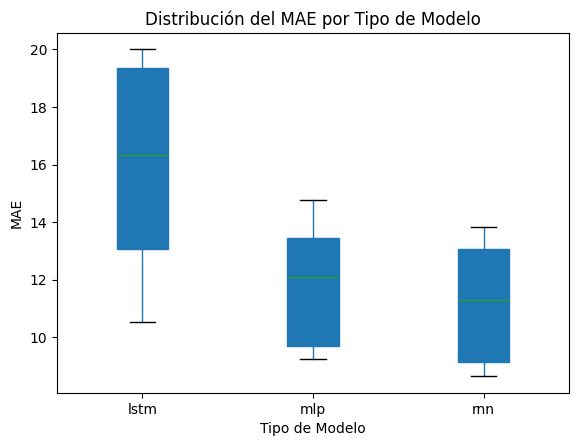

In [227]:
dfval.boxplot(column='mae', by='model', grid=False, patch_artist=True)
plt.title('Distribución del MAE por Tipo de Modelo')
plt.suptitle('')
plt.xlabel('Tipo de Modelo')
plt.ylabel('MAE')
plt.show()

**Key insights**
1. El modelo LSTM presentó el mayor MAE registrado en las corridas del algoritmo, de hecho en el 50% de los casos tiene 16 unidades de MAE o más, esto es menor que lo alcanzado incluso con el modelo ARIMA del capítulo anterior y la suavización exponencial simple. Importante considerar que en los parámetros de la LSTM no utilizamos la función de activación RELU que sí consideramos para el modelo MLP y RNN.
2. El primer puesto lo ocupó la red neuronal RNN, que alcanzó el valor mínimo entre los 3 modelos, de hecho su valor máximo está todavía por debajo del modelo MLP. En el 50% de los casos tiene aproximadamente menos de 12 unidades de MAE, la mejor mediana entre los 3 modelos.

Ahora con respecto a los parámetros utilizados dentro del modelo, podemos observar lo siguiente:

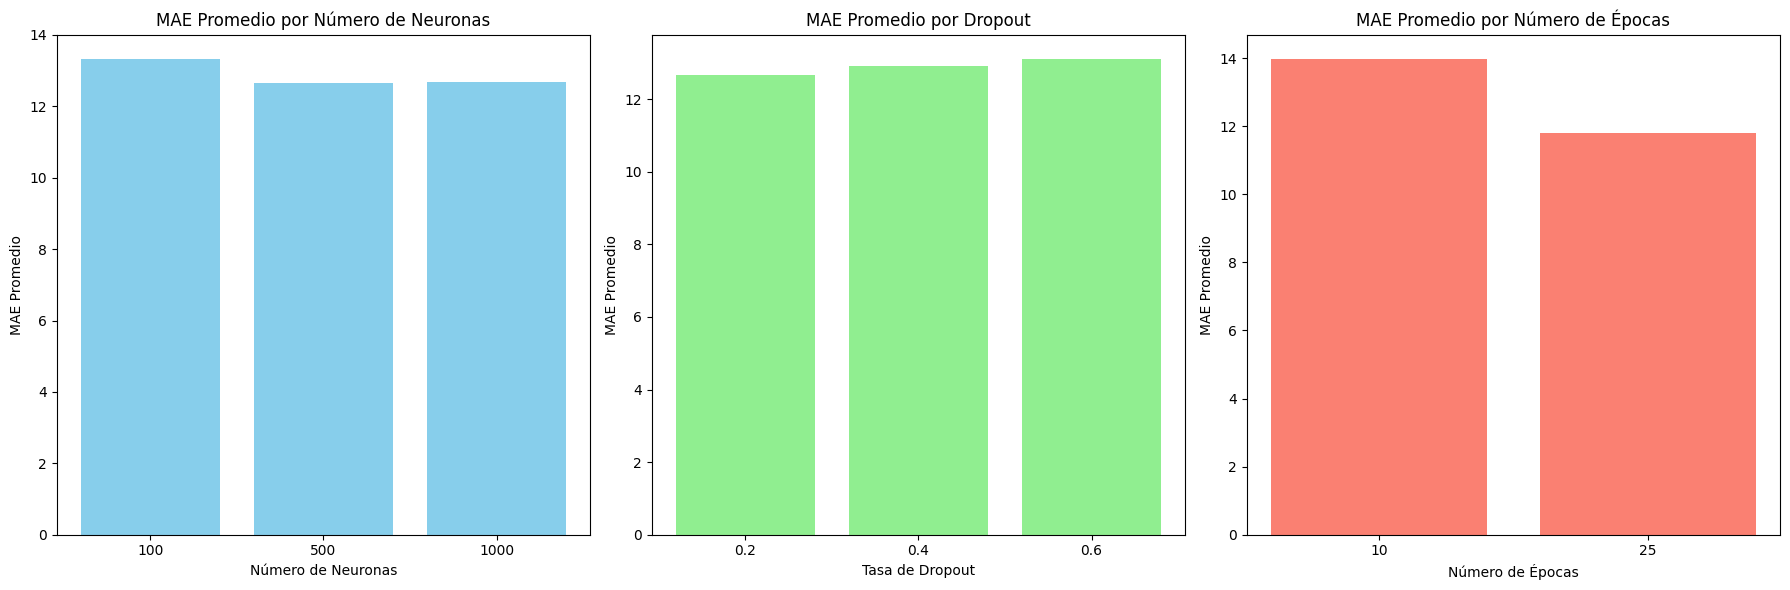

In [221]:
mae_neurons = dfval.groupby('neurons')['mae'].mean().reset_index()
mae_dropout = dfval.groupby('dropout')['mae'].mean().reset_index()
mae_epochs = dfval.groupby('epochs')['mae'].mean().reset_index()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.bar(mae_neurons['neurons'].astype(str), mae_neurons['mae'], color='skyblue')
plt.title('MAE Promedio por Número de Neuronas')
plt.xlabel('Número de Neuronas')
plt.ylabel('MAE Promedio')

plt.subplot(1, 3, 2)
plt.bar(mae_dropout['dropout'].astype(str), mae_dropout['mae'], color='lightgreen')
plt.title('MAE Promedio por Dropout')
plt.xlabel('Tasa de Dropout')
plt.ylabel('MAE Promedio')

plt.subplot(1, 3, 3)
plt.bar(mae_epochs['epochs'].astype(str), mae_epochs['mae'], color='salmon')
plt.title('MAE Promedio por Número de Épocas')
plt.xlabel('Número de Épocas')
plt.ylabel('MAE Promedio')

plt.tight_layout()
plt.show()

**Key insights**
1. Con respecto a las neuronas, se observa que a medida que se incrementó el valor se consiguió un mejor MAE, sin embargo la diferencia es mínimo entre 500 y 1000 neuronas, para optimizar el código se pueden dejar solo 500 y se reducen el número de combinaciones para evaluar.
2. Con respecto al dropout observamos que a medida que aumentamos la tasa, aumenta el MAE, podríamos buscar probar una tasa de 0.1 en evaluaciones posteriores para conocer si esto mejora el desempeño del modelo.
3. Con respecto al número de épocas el desempeñó sí presentó una alta variación, de hecho cuando se usaron 25 épocas el MAE disminuó casi 2 unidades en promedio, por lo que quisiéramos probar en otra ocasión un número de épocas mayor y conocer si eso mejora el desempeño.

### 7.2 Top 15 mejores MAE en el conjunto de testing

Analicemos ahora los modelos que alcanzaron el mejor MAE en el testing, sus pronósticos y el tipo de modelo.

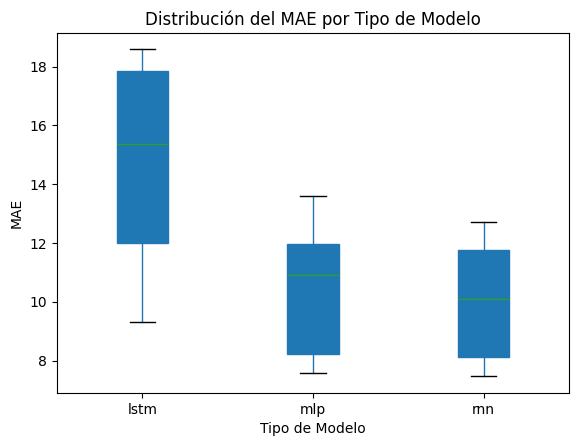

In [232]:
dftest.boxplot(column='mae', by='model', grid=False, patch_artist=True)
plt.title('Distribución del MAE por Tipo de Modelo')
plt.suptitle('')
plt.xlabel('Tipo de Modelo')
plt.ylabel('MAE')
plt.show()

**Key insights**
1. En el test se mantuvo el mismo podio, sin embargo la red LSTM mejoró su resultado MAE promedio.
2. La RNN emparejó más sus resultados con la red MLP, sin embargo obtuvo de nuevo el menor valor MAE registrado. En el 50% de los conjuntos de test que pronosticó, de hecho, obtuvo un valor cercano a 10 unidades, mientras que la MLP un valor por encima de 11.

In [235]:
dftest.sort_values("mae",ascending = True).head(15)

,model,neurons,epochs,dropout,mape,mae,mse,rmse,r2
69,rnn,100,25,0.6,inf,7.464502,113.344922,10.646357,0.683541
91,mlp,1000,10,0.2,inf,7.573771,112.843935,10.622803,0.684940
75,rnn,500,10,0.4,inf,7.791840,126.241094,11.235706,0.647535
96,rnn,1000,10,0.6,inf,7.800657,123.804271,11.126737,0.654339
84,rnn,500,25,0.4,inf,7.845781,128.819801,11.349881,0.640336
76,mlp,500,10,0.4,inf,7.956229,121.193801,11.008806,0.661627
54,rnn,100,10,0.2,inf,7.956674,129.640784,11.385991,0.638043
78,rnn,500,10,0.6,inf,8.029625,125.188040,11.188746,0.650476
63,rnn,100,25,0.2,inf,8.034240,134.584676,11.601064,0.624240
79,mlp,500,10,0.6,inf,8.057249,123.130328,11.096411,0.656221


**Key insights Top 15**
1. El mejor MAE fue de 7.46 unidades con el modelo RNN, casi un 50% menos que el conseguido con ARIMA en el capítulo anterior. Además aumentó el R2 a 68% ante 23% que presentó ARIMA.
2. En segundo lugar se alcanzó un MAE de 7.57 unidades, en este caso con el modelo MLP, que de hecho presenta un mejor R2 que la serie RNN, es decir logró capturar un poco mejor la variabilidad de la respuesta.
3. Ahora si observamos el top 15 de mejores modelos, podemos observar que no hay ningún caso en el que se encuentre el modelo LSTM. De hecho el 66% de los modelos que están en este top fueron calculados a partir de RNN.
4. Curiosamente mejor modelo tiene parámetros 100 neuronas, 25 épocas y 0.6 de drop-out, lo que no coincide con el análisis del entrenamiento, en donde 100 neuronas y 0.6 de drop-out estaba relacionado con los menores MAE.
5. En esta tabla no se observa, pero **la partición mejoró cuando se usaban 4 datos como input layer**.

### 7.3 Pronóstico con el mejor modelo

In [236]:
s = 4
X_train, y_train = makeXy(train_esc, s+1)
X_val, y_val = makeXy(val_esc, s+1)
X_test, y_test = makeXy(test_esc, s+1)
    
X_valr, y_valr = makeXy(val, s+1)
X_testr, y_testr = makeXy(test, s+1)

In [237]:
model = create_RNN(100, s, 0.6)
best_model = select_model(model, eph, X_train, y_train, X_val, y_val)

val_pred = forecast_nw(best_model, X_val)
test_pred = forecast_nw(best_model, X_test)

Epoch 1/25
65/65 - 2s - 25ms/step - loss: 0.0494 - val_loss: 0.0498
Epoch 2/25
65/65 - 0s - 6ms/step - loss: 0.0283 - val_loss: 0.0447
Epoch 3/25
65/65 - 0s - 6ms/step - loss: 0.0249 - val_loss: 0.0330
Epoch 4/25
65/65 - 0s - 5ms/step - loss: 0.0212 - val_loss: 0.0360
Epoch 5/25
65/65 - 0s - 5ms/step - loss: 0.0199 - val_loss: 0.0339
Epoch 6/25
65/65 - 0s - 6ms/step - loss: 0.0190 - val_loss: 0.0317
Epoch 7/25
65/65 - 0s - 6ms/step - loss: 0.0189 - val_loss: 0.0290
Epoch 8/25
65/65 - 0s - 5ms/step - loss: 0.0175 - val_loss: 0.0310
Epoch 9/25
65/65 - 0s - 5ms/step - loss: 0.0180 - val_loss: 0.0306
Epoch 10/25
65/65 - 0s - 5ms/step - loss: 0.0165 - val_loss: 0.0303
Epoch 11/25
65/65 - 0s - 5ms/step - loss: 0.0164 - val_loss: 0.0304
Epoch 12/25
65/65 - 0s - 5ms/step - loss: 0.0157 - val_loss: 0.0313
Epoch 13/25
65/65 - 0s - 6ms/step - loss: 0.0153 - val_loss: 0.0310
Epoch 14/25
65/65 - 0s - 5ms/step - loss: 0.0159 - val_loss: 0.0295
Epoch 15/25
65/65 - 0s - 6ms/step - loss: 0.0154 - val_l

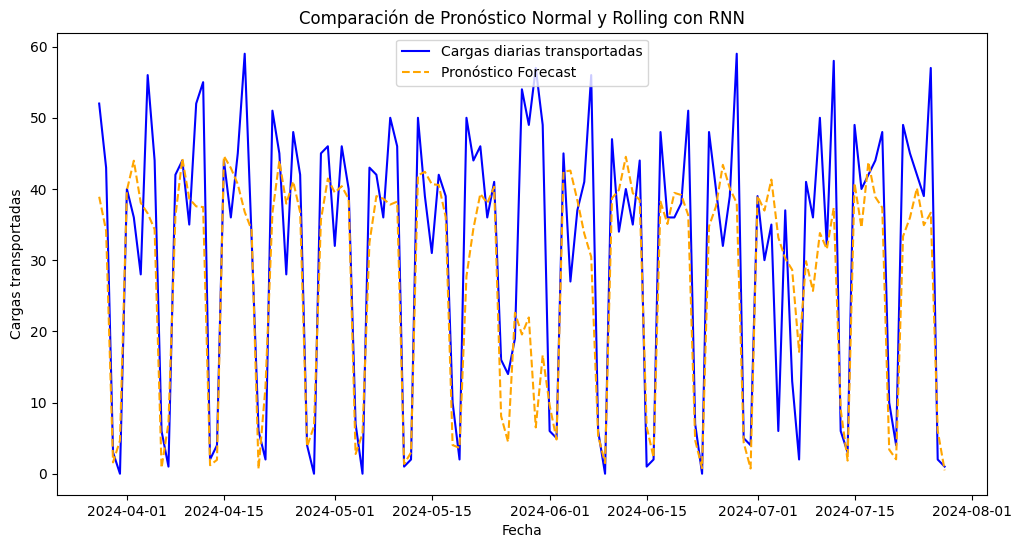

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(test[5:].index, y_testr, label='Cargas diarias transportadas', color='blue')
plt.plot(test[5:].index, test_pred, label='Pronóstico Forecast', color='orange', linestyle='--')
plt.title('Comparación de Pronóstico Normal y Rolling con RNN')
plt.xlabel('Fecha')
plt.ylabel('Cargas transportadas')
plt.legend()
plt.show()

Se observa un mucho mejor ajuste que el anteriormente obtenido usando modelos de tipo ARIMA y suavización exponencial.